# 1. Preparing the data
### First, we load the images and resize them to 224x224, which is an input size for our segmentation neural networks

In [1]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root_input = "/kaggle/input/ph2-dataset/trainx"
root_gts = "/kaggle/input/ph2-dataset/trainy"

for file in os.listdir(root_input):
    images.append(imread(os.path.join(root_input, file)))
    lesions.append(imread(os.path.join(root_gts, file.split('.')[0]+'_lesion.bmp')))

In [3]:
# resize also scales the pixel intensities to (0,1)

from skimage.transform import resize
size = (224, 224)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


### We check that the length of the dataset is correct:

In [5]:
len(images), len(lesions)

(200, 200)

### And visualize several images and targets:

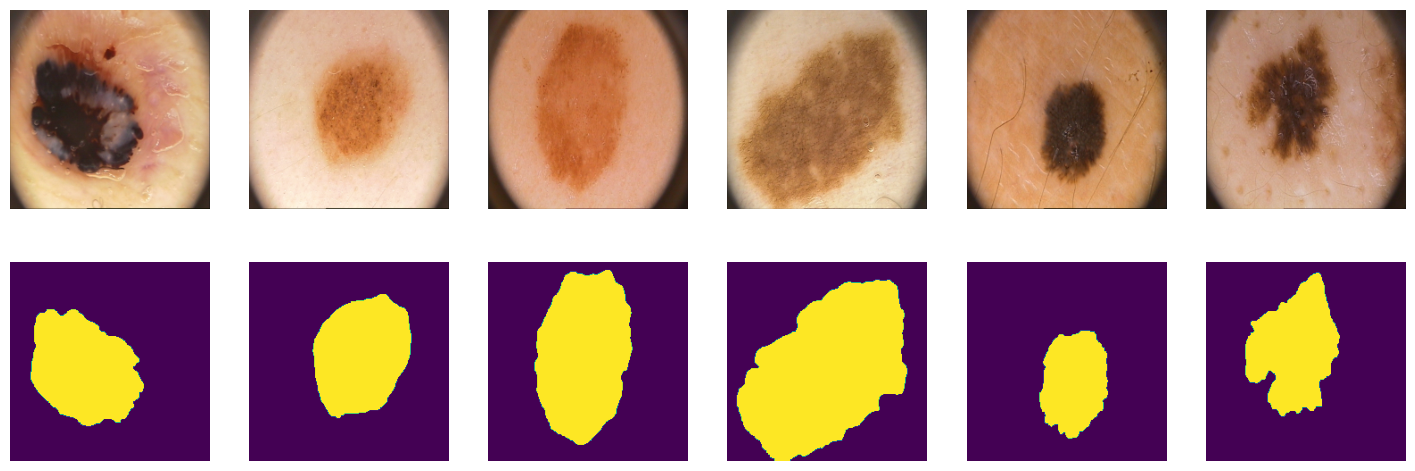

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

### Let's split the dataset into train, validation and test parts:

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


### Data augmentation

In [9]:
import random
import cv2
import numpy as np

class VerticalFlip:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            new_img = cv2.flip(img, 0)
            if mask is not None:
                new_mask = cv2.flip(mask, 0)
        return new_img, new_mask


class HorizontalFlip:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            new_img = cv2.flip(img, 1)
            if mask is not None:
                new_mask = cv2.flip(mask, 1)
        return new_img, new_mask


class RandomFlip:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            d = random.randint(-1, 1)
            new_img = cv2.flip(img, d)
            if mask is not None:
                new_mask = cv2.flip(mask, d)
        return new_img, new_mask


class Transpose:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            new_img = img.transpose(1, 0, 2)
            if mask is not None:
                new_mask = mask.transpose(1, 0)
        return new_img, new_mask


class RandomRotate90:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            factor = random.randint(0, 4)
            new_img = np.rot90(img, factor)
            if mask is not None:
                new_mask = np.rot90(mask, factor)
        return new_img, new_mask


class Rotate:
    def __init__(self, limit=90, prob=0.8):
        self.prob = prob
        self.limit = limit

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            angle = random.uniform(-self.limit, self.limit)

            height, width = img.shape[0:2]
            mat = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            new_img = cv2.warpAffine(img, mat, (height, width),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                new_mask = cv2.warpAffine(mask, mat, (height, width),
                                      flags=cv2.INTER_NEAREST,
                                      borderMode=cv2.BORDER_REFLECT_101)

        return new_img, new_mask
    
class DataAugmentation:
    def __init__(self, transforms=[]):
        self.transforms = transforms

    def __call__(self, img, mask=None):
        augmented_images = []
        augmented_masks = []
        for transform in self.transforms:
            augmented_img, augmented_mask = transform(img, mask)
            augmented_images.append(augmented_img)
            augmented_masks.append(augmented_mask)
        return augmented_images, augmented_masks

2


/tmp/ipykernel_34/2053991358.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i+1)


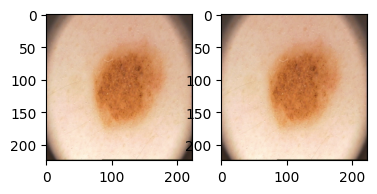

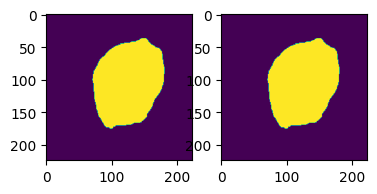

In [10]:
img = X[1]
mask = Y[1]
plt.imshow(img)

# Define your individual augmentation techniques
vertical_flip = VerticalFlip(prob=0.8)
horizontal_flip = HorizontalFlip(prob=0.8)
random_flip = RandomFlip(prob=0.8)
transpose = Transpose(prob=0.8)
random_rotate_90 = RandomRotate90(prob=0.8)
rotate = Rotate(limit=90, prob=0.8)

# Create a DataAugmentation instance with a list of transformations
data_augmentation = DataAugmentation(transforms=[vertical_flip, horizontal_flip])

# Apply data augmentation to an image
augmented_images, augmented_masks = data_augmentation(img, mask)

# Print the number of augmented images
print(len(augmented_images))

# Display each augmented image
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_img)
plt.show()

for i, augmented_mask in enumerate(augmented_masks):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_mask)
plt.show()

In [11]:
import os

# Define the directories for augmented images and masks
augmented_train_X_dir = "/kaggle/working/augment/trainx/"
augmented_train_Y_dir = "/kaggle/working/augment/trainy/"

# Create directories if they don't exist
os.makedirs(augmented_train_X_dir, exist_ok=True)
os.makedirs(augmented_train_Y_dir, exist_ok=True)

# Loop through each image and mask pair
for i, (img, mask) in enumerate(zip(X[tr], Y[tr])):
    # Apply data augmentation
    augmented_images, augmented_masks = data_augmentation(img, mask)

    # Save augmented images
    for j, aug_img in enumerate(augmented_images):
        img_filename = f"img_{i}_{j}.bmp"
        img_path = os.path.join(augmented_train_X_dir, img_filename)
        cv2.imwrite(img_path, aug_img)

    # Save augmented masks
    for j, aug_mask in enumerate(augmented_masks):
        mask_filename = f"img_{i}_{j}_lesion.bmp"
        mask_path = os.path.join(augmented_train_Y_dir, mask_filename)
        cv2.imwrite(mask_path, aug_mask)
    print("Img path:", img_path, " Mask path:", mask_path)


Img path: /kaggle/working/augment/trainx/img_0_1.bmp  Mask path: /kaggle/working/augment/trainy/img_0_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_1_1.bmp  Mask path: /kaggle/working/augment/trainy/img_1_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_2_1.bmp  Mask path: /kaggle/working/augment/trainy/img_2_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_3_1.bmp  Mask path: /kaggle/working/augment/trainy/img_3_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_4_1.bmp  Mask path: /kaggle/working/augment/trainy/img_4_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_5_1.bmp  Mask path: /kaggle/working/augment/trainy/img_5_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_6_1.bmp  Mask path: /kaggle/working/augment/trainy/img_6_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_7_1.bmp  Mask path: /kaggle/working/augment/trainy/img_7_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_8_1.bmp  Mask path: /kaggle/working

In [12]:
images = []
lesions = []
from skimage.io import imread
import os
root_input = "/kaggle/working/augment/trainx"
root_gts = "/kaggle/working/augment/trainy"

for file in os.listdir(root_input):
    images.append(imread(os.path.join(root_input, file)))
    lesions.append(imread(os.path.join(root_gts, file.split('.')[0] + "_lesion.bmp")))

# resize also scales the pixel intensities to (0,1)

from skimage.transform import resize
size = (224, 224)
augmented_X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
augmented_Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

import numpy as np
augmented_X = np.array(augmented_X, np.float32)
augmented_Y = np.array(augmented_Y, np.float32)
print(f'Loaded {len(augmented_X)} images')

# ix = np.random.choice(len(X), len(X), False)
# tr, val, ts = np.split(ix, [100, 150])

# from torch.utils.data import DataLoader
# batch_size = 4
# data_augmented_tr = DataLoader(list(zip(np.rollaxis(augmented_X, 3, 1), augmented_Y[..., np.newaxis])), 
#                      batch_size=batch_size, shuffle=True)

Loaded 200 images


In [13]:
np.rollaxis(X[tr], 3, 1).shape, Y[tr, np.newaxis].shape

((100, 3, 224, 224), (100, 1, 224, 224))

In [14]:
np.rollaxis(augmented_X, 3, 1).shape, augmented_Y[:, np.newaxis].shape

((200, 3, 224, 224), (200, 1, 224, 224))

In [15]:
# X_train = np.vstack((np.rollaxis(X[tr], 3, 1), np.rollaxis(augmented_X, 3, 1)))
# Y_train = np.vstack((Y[tr, np.newaxis], augmented_Y[:, np.newaxis]))
X_train = np.rollaxis(X[tr], 3, 1)
Y_train = Y[tr, np.newaxis]
X_train.shape, Y_train.shape

((100, 3, 224, 224), (100, 1, 224, 224))

### Next, we use PyTorch Dataloader to wrap our datasets:

In [16]:
from torch.utils.data import DataLoader
batch_size = 4
data_tr = DataLoader(list(zip(X_train, Y_train)), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

### And set the GPU device for training:

In [17]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. Segmentation network architectures:
#### Here, we will implememt two convolutional networks for segmentation: TernausNet11

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [19]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            vgg - encoder pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.num_classes = num_classes
        
        if pretrained:
            self.encoder = models.vgg11(weights=models.vgg.VGG11_Weights.IMAGENET1K_V1).features
        else:
            self.encoder = models.vgg11().features
        

        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[3],
                                   self.relu)

        self.conv3 = nn.Sequential(
            self.encoder[6],
            self.relu,
            self.encoder[8],
            self.relu,
        )
        self.conv4 = nn.Sequential(
            self.encoder[11],
            self.relu,
            self.encoder[13],
            self.relu,
        )

        self.conv5 = nn.Sequential(
            self.encoder[16],
            self.relu,
            self.encoder[18],
            self.relu,
        )

        self.center = DecoderBlock(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 4, is_deconv=is_deconv)
        self.dec3 = DecoderBlock(256 + num_filters * 4, num_filters * 4 * 2, num_filters * 2, is_deconv=is_deconv)
        self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv=is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)

        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))
        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out

In [20]:
%%capture
!pip install torchsummary

In [21]:
from torchsummary import summary

model = UNet11(pretrained=True)
model.to(device)
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 162MB/s]  


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
              ReLU-7         [-1, 64, 224, 224]               0
              ReLU-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
           Conv2d-11        [-1, 128, 112, 112]          73,856
             ReLU-12        [-1, 128, 112, 112]               0
             ReLU-13        [-1, 128, 112, 112]               0
             ReLU-14        [-1, 128, 1

# 3. Metric, training function and the training process:

## Metric

For quality assessment, we will use the IoU (intersection over union) metric defined as:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [22]:
def iou_pytorch(outputs, labels):
    outputs = outputs.squeeze().byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels =(labels).squeeze().byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou

## Loss function

To start the training of our model, we will implement two loss functions:


**1. Binary cross-enthropy loss (BCE)**

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is our target and $\hat y$ is an output of the model. $\sigma$ is a logistic function 

**2. BCE with improved numerical stability:**

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [23]:
def BCEWithLogits(y_pred, y_true):
    bcelogits_loss = -y_true * torch.log(torch.sigmoid(y_pred)) - (1 - y_true) * torch.log(torch.sigmoid(1 - y_pred)) 
    # работает хорошо без упрощения
    
    return bcelogits_loss

In [24]:
def BCE_stabilized(y_pred, y_true):
    loss = torch.max(y_pred, torch.zeros_like(y_pred)) - y_pred*y_true + torch.log(1+torch.exp(-torch.abs(y_pred)))
    return loss

## Training function

#### Let's define our training function below, which will pack several features:
1. Fitting the model with specified optimizer and scheduler over the selected number of epochs
2. Calculating the IoU metric and loss over each epoch for training and validation datasets and save the training history
3. Visualization of two images from last batch of validation dataset in every epoch with the corresponding segmented masks

In [25]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, sched = None, freq = 1):
    history = []
    for epoch in range(epochs):
        tic = time()
        print(f'Epoch {epoch+1} of {epochs}')
        avg_val_loss = 0
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch)
            loss.mean().backward()
            opt.step()

            # calculate train loss
            avg_loss += loss.mean() / len(data_tr)
        toc = time()
        print(f'loss: {avg_loss}')
        
        # calculate val loss and metrics
        model.eval()  # testing mode
        with torch.no_grad():
            for X_val, Y_val in data_val:
                # data to device
                X_val, Y_val = X_val.to(device), Y_val.to(device)
                Y_val_pred = model(X_val)
                loss_val =  loss_fn(Y_val_pred, Y_val)
                avg_val_loss += loss_val.mean() / len(data_val)
            Y_hat = (torch.sigmoid(model(X_val).squeeze()) > 0.5).to(int)
            val_metric = iou_pytorch(Y_hat, Y_val)
            Y_train_hat = (torch.sigmoid(model(X_batch).squeeze()) > 0.5).to(int)
            train_metric = iou_pytorch(Y_train_hat, Y_batch)
        # make a scheduler step
        if sched:
            if epoch % freq == 0:
                sched.step()
                
        # save the training history
        history.append((avg_loss.item(), avg_val_loss.item(), train_metric.mean().item(), val_metric.mean().item()))
        
        # Visualize tools
        clear_output(wait=True)
        Y_hat = Y_hat.detach().cpu().numpy()
        plt.figure(figsize = (4,4))
        for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(Y_hat[k, :, :], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return history

## Prediction and scoring

We need to implement functions which will analyze the performance of the trained models

In [26]:
# predict function receives a numpy array of data

def predict(model, data):
    test_dataset = np.rollaxis(data, 3, 1)
    model.eval()  # testing mode
    Y_pred = np.zeros(len(data), dtype = 'object')
    idx = 0
    with torch.no_grad():
        X = torch.FloatTensor(test_dataset).to(device)
        preds = (torch.sigmoid(model(X)).squeeze() > 0.5).to(int).cpu().numpy()
        for X in preds:
                Y_pred[idx] = X
                idx+=1
    return Y_pred

In [27]:
# this function returns an IoU value over the dataset (training or validation)

def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = (torch.sigmoid(model(X_batch.to(device)).squeeze()) > 0.5).to(int)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

# First training

In [28]:
# Let's clear the GPU memory just in case

import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

93678080

### Unstable BCE loss 

#### Note: below, the training parameters such as optimizer, Lr, etc. were selected to provide optimal performance for every model

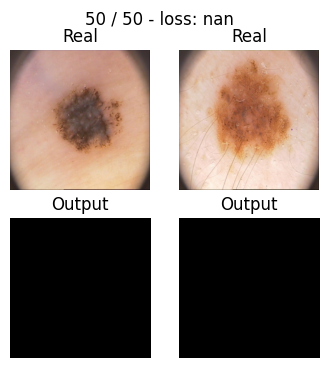

In [29]:
max_epochs = 50
opt = torch.optim.AdamW(model.parameters(), lr = 4e-5, weight_decay = 1e-4)
history_bce = train(model, opt, BCEWithLogits, max_epochs, data_tr, data_val)

### Okay, let's check how the predict function works:

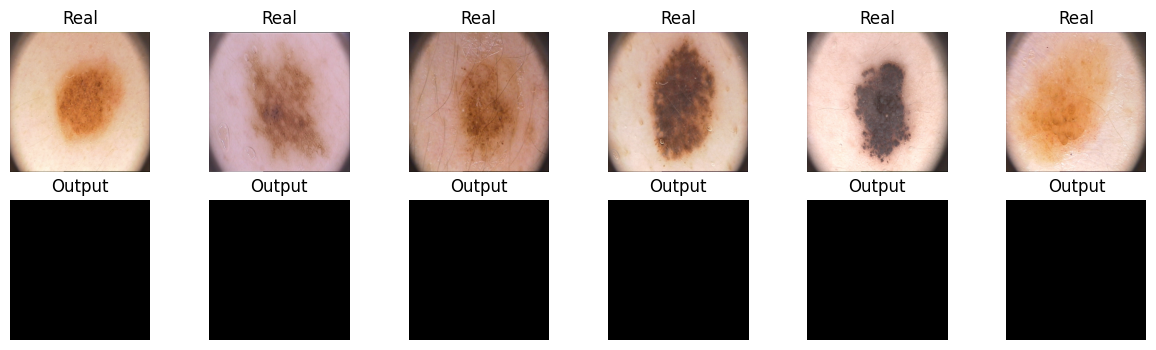

In [30]:
Y_pred = predict(model, X[ts])

for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(X[ts][k])
    plt.title('Real')
    plt.axis('off')
    
    plt.subplot(2, 6, k+7)
    plt.imshow(Y_pred[k], cmap='gray')
    plt.title('Output')
    plt.axis('off')

# it works okay and the model is strong enough to train on our small dataset!

### Visualization of the training process:

#### Let's make a function that will plot IoU metric and loss over the training process and dump the training history to a file

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

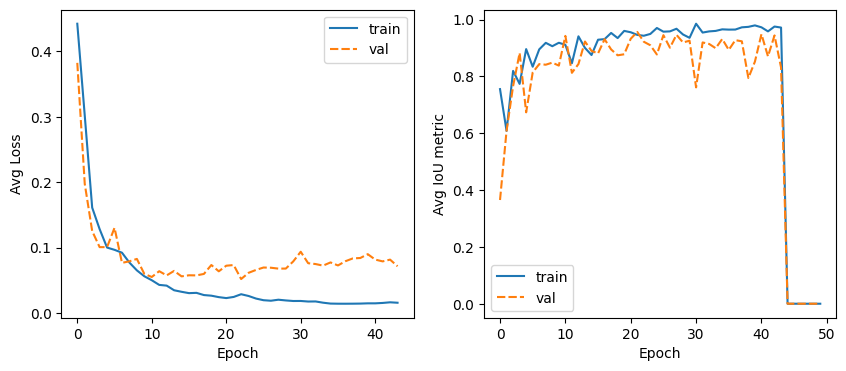

In [31]:
def visualize_and_save(history, savename):
    loss_tr, loss_val, metric_tr, metric_val = zip(*history)
    from seaborn import lineplot
    graphs = plt.figure(figsize = (10, 4))
    ax1 = plt.subplot(1,2,1)
    lineplot({'train': loss_tr, 'val' : loss_val})
    plt.xlabel('Epoch')
    plt.ylabel('Avg Loss')
    ax2 = plt.subplot(1,2,2)
    lineplot({'train':metric_tr, 'val':metric_val})
    plt.xlabel('Epoch')
    plt.ylabel('Avg IoU metric');
    
    # we save the training history for future use
    import pickle
    with open(savename, 'wb') as file:
        pickle.dump(history, file)

    
visualize_and_save(history_bce, 'history_bce')

#### Calculate IoU score on all of the validation data:

In [32]:
round(score_model(model, iou_pytorch, data_val),3)

0.0